In [1]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
from collections import OrderedDict
import numpy as np
import seaborn as sns
from multiprocessing import Pool
import pandas
from itertools import product as iterproduct, groupby, chain, repeat
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/lib/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [2]:
# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
# }

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment.62pA_true_events.pickle",
#      "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# #     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
# }

args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1_5000.alignment_true_events.pickle",
     "ref": "/home/ibis/gregor.sturm/nanopore/NanoporeData/PublicData/LomanLab_MAP-006/ecoli_mg1655.fa",
    "model" : "/home/ibis/gregor.sturm/nanopore/own/notebooks/05_MAP006-basecaller/loman006-1.model.computed.pickle",
    "ncores" : 24
#     "ref": "/home/sturm/Downloads/lambda_ref.fasta"
}

In [3]:
NMER = 6
CONTEXT = 100
MEAN = 59

In [4]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks


In [5]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [6]:
HMM_PARAMS = pickle.load(open(args["model"], 'rb'))
HMM_PARAMS = HMM_PARAMS["/opt/chimaera/model/r7.3_e6_70bps_6mer/template_median68pA.model"]

In [7]:
HMM_PARAMS[HMM_PARAMS["kmer"] == "AAAAAA"]

,kmer,level_mean,level_stdv,sd_mean,sd_stdv,weight
0,AAAAAA,62.962374,0.845662,0.681821,0.173284,1


In [8]:
ref = load_ref(args["ref"])

['>gi|556503834|ref|NC_000913.3| Escherichia coli str. K-12 substr. MG1655, complete genome']
AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


In [9]:
def _get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    context = ref[start:end]
    
    if len(context) != end-start:
        print(start, end, len(ref), len(context), end-start)
        raise IndexError
    else: return context

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = 0
    return _get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = length
    return _get_context(event, offset, offset+n)

In [10]:
test_event = true_events[2000]
print(test_event['kmer'], _get_context(test_event, 0,6))
assert test_event['kmer'] == _get_context(test_event, 0, 6), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    _get_context(test_event, -20, 26))

TGCTCA TGCTCA


## Analysis 

In [11]:
all_kmers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_kmers)

In [12]:
def prepare_events(kmer):
    template_events = [ev for ev in ev_map[kmer] if not np.isnan(ev["template.mean"])]
    template_events = [ev for ev in template_events if 
                   ev["ref_position"] > CONTEXT+NMER+1 and ev["ref_position"] < len(ref)-CONTEXT-NMER-1]
    print("kmer {0}".format(kmer))
    print(">>genomic_positions {0}".format(len(set([ev["ref_position"] for ev in template_events]))))
    print(">>total_events {0}".format(len(template_events)))
    return template_events

In [13]:
%%capture
template_events = [prepare_events(kmer) for kmer in all_kmers]

In [14]:
context = (-20, 26)
context_buckets = [{nt: [] for nt in NTS} for _ in range(*context)]

In [15]:
for k, kmer_evs in enumerate(template_events): 
    if len(kmer_evs) == 0: continue
    param_mean = float(HMM_PARAMS[HMM_PARAMS["kmer"] == kmer_evs[0]["kmer"]]["level_mean"])
    for ev in kmer_evs:
        nt_context = _get_context(ev, *context)
        for i, pos in enumerate(range(*context)): 
            diff = ev["template.mean"] - param_mean
            if not np.isnan(diff):
                context_buckets[i][nt_context[i]].append(diff)
    sys.stdout.write("\rdone {0:%}".format(k/len(template_events)))

done 99.975586%

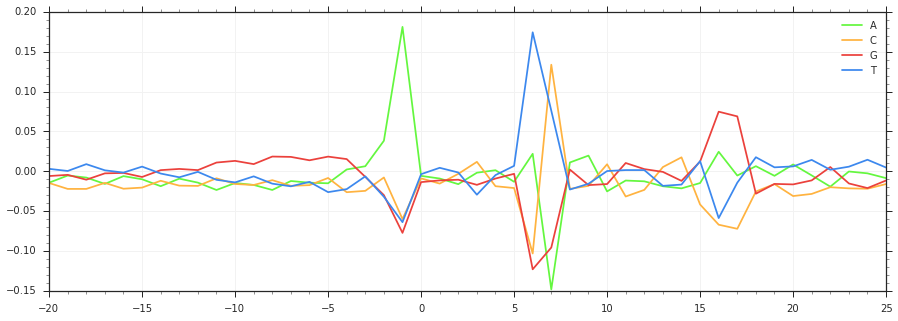

In [16]:
fig, ax = subplots(figsize=(15, 5))
for nt in NTS:
    ax.plot(range(*context), [median(pos[nt]) for pos in context_buckets], color=NT_COLORS[nt], label=nt)
ax.legend()
ax.minorticks_on()

In [ ]:
context = (-20, 26)
context_buckets = [{nt: [] for nt in NTS} for _ in range(*context)]

In [ ]:
for i, kmer_evs in enumerate(template_events):     
    if len(kmer_evs) == 0: continue
    for ev in kmer_evs:
        nt_context = _get_context(ev, *context)
        for i, pos in enumerate(range(*context)): 
            diff = ev["template.end"] - ev["template.start"]
            if not np.isnan(diff):
                context_buckets[i][nt_context[i]].append(diff)
    sys.stdout.write("\rdone {0:%}".format(i/len(template_events)))

done 1.098633%

In [ ]:
fig, ax = subplots(figsize=(15, 5))
for nt in NTS:
    ax.plot(range(*context), [median(pos[nt]) for pos in context_buckets], color=NT_COLORS[nt], label=nt)
ax.legend()
ax.minorticks_on()